In [122]:
import numpy as np
import pandas as pd

import os
import librosa
import sounddevice as sd

import pickle

import scipy
from scipy.stats import skew
from tqdm import tqdm, tqdm_pandas

tqdm.pandas()

from sklearn import svm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [123]:
#Specifying paths
dataPath = 'Audio/'
metaData = pd.read_csv('metadata.csv')

In [124]:
def featuresExtractor(file):
    audio, sRate = librosa.load(file, res_type='kaiser_fast') #Load file prioritising speed, cuz we're doin' machine learning, not music
    mfcc = librosa.feature.mfcc(y=audio, sr=sRate, n_mfcc=40)
    mfccScaled = np.mean(mfcc.T, axis=0) #Find the mean from the transposed array

    return mfccScaled

In [125]:
#This is used to create an array with thinggy inside of it, takes quite a while to load
features = []

for index, row in tqdm(metaData.iterrows()):
    fileName = os.path.join(os.path.abspath(dataPath), str(row["Note"]) + '/', str(row["Name"]))
    labels = row["Note"]
    data = featuresExtractor(fileName)
    features.append([data, labels])

1760it [01:08, 25.68it/s]


In [126]:
df = pd.DataFrame(features, columns=['features', 'class'])
df.head()

,features,class
0,"[-618.94244, 160.39342, 80.086685, 43.61678, 1...",Am
1,"[-652.1719, 152.57881, 55.81178, 39.47468, 5.2...",Am
2,"[-232.73901, 144.85373, -17.409685, 36.19547, ...",Am
3,"[-245.83714, 154.66487, -12.436771, 36.953526,...",Am
4,"[-243.50058, 135.22137, -12.819307, 36.791035,...",Am


In [127]:
key = df['class']
newClass = []

for i in range(len(df.index)):
    if key[i] == 'Am':
        newClass.append(0)
    elif key[i] == 'Bb':
        newClass.append(1)
    elif key[i] == 'Bdim':
        newClass.append(2)
    elif key[i] == 'C':
        newClass.append(3)
    elif key[i] == 'Dm':
        newClass.append(4)
    elif key[i] == 'Em':
        newClass.append(5)
    elif key[i] == 'F':
        newClass.append(6)
    elif key[i] == 'G':
        newClass.append(7)

df['nClass'] = np.array(newClass).tolist()

In [128]:
df

,features,class,nClass
0,"[-618.94244, 160.39342, 80.086685, 43.61678, 1...",Am,0
1,"[-652.1719, 152.57881, 55.81178, 39.47468, 5.2...",Am,0
2,"[-232.73901, 144.85373, -17.409685, 36.19547, ...",Am,0
3,"[-245.83714, 154.66487, -12.436771, 36.953526,...",Am,0
4,"[-243.50058, 135.22137, -12.819307, 36.791035,...",Am,0
...,...,...,...
1755,"[-584.32574, 172.95914, 53.141903, 46.334255, ...",G,7
1756,"[-625.7727, 162.65997, 53.851185, 44.557674, 2...",G,7
1757,"[-256.16782, 143.86983, -17.850994, 37.48406, ...",G,7
1758,"[-259.35522, 138.84924, -16.882029, 36.305145,...",G,7


In [129]:
col = []
for i in range(0, 40):
    something = str(i)
    col.append(something)

df1 = pd.DataFrame(df["features"].to_list(), columns=col)

df1

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-618.942444,160.393417,80.086685,43.616779,14.460505,10.505781,-1.634336,9.061604,-6.658968,-17.145210,...,-5.538134,-2.528838,-2.096127,-3.468306,-7.555685,-8.537477,-9.153907,-4.758424,-3.733159,-3.645467
1,-652.171875,152.578812,55.811779,39.474682,5.228724,13.362817,-12.343469,6.035104,-16.504841,-21.286066,...,-8.673594,-1.228811,4.004219,-0.051157,-9.059593,-11.544678,-9.977971,-4.663665,-8.513506,-0.086753
2,-232.739014,144.853729,-17.409685,36.195469,-18.203836,4.630744,-18.414518,-7.856843,-3.435359,-21.727976,...,-14.784521,-3.778725,-4.399934,-10.644004,-23.029003,-21.346174,-11.698085,-8.049029,-7.694691,0.038161
3,-245.837143,154.664871,-12.436771,36.953526,-18.951691,3.777970,-16.962626,-2.292308,-1.753302,-19.302774,...,-11.187586,-7.176183,-10.762504,-10.759489,-16.033743,-20.117510,-18.674934,-9.571517,-5.543511,-2.466156
4,-243.500580,135.221375,-12.819307,36.791035,-11.724051,2.011731,-14.027493,-5.956964,-4.172876,-16.582216,...,-12.986355,-7.884853,-7.708410,-9.195906,-15.987913,-18.735260,-14.975236,-9.409391,-5.312215,-2.312731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,-584.325745,172.959137,53.141903,46.334255,18.965708,20.297340,-1.197668,5.549225,-4.458586,-5.435139,...,-6.489536,-7.263323,-1.716272,5.112793,3.471991,0.658892,-2.910301,-1.210557,-8.325418,-10.180007
1756,-625.772705,162.659973,53.851185,44.557674,24.074991,12.417348,-1.293463,-2.806634,-4.488955,-6.242919,...,-6.615290,-11.148757,-5.140619,3.216914,7.622913,5.862616,0.594640,-6.218788,-9.727440,-5.703119
1757,-256.167816,143.869827,-17.850994,37.484058,-20.604940,-3.072173,-24.476738,-12.423444,-12.857989,-25.341011,...,-16.213522,-14.252097,-10.975779,-1.162763,4.168386,2.484266,-4.621086,-7.033581,-7.984859,-12.167087
1758,-259.355225,138.849243,-16.882029,36.305145,-19.356407,1.128517,-17.564701,-12.888145,-12.381765,-20.388418,...,-9.625761,-8.290325,-8.325219,-2.122793,2.029476,4.309823,-1.375207,-5.782552,-6.781487,-10.488054


In [130]:
X = df1.copy()
X

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-618.942444,160.393417,80.086685,43.616779,14.460505,10.505781,-1.634336,9.061604,-6.658968,-17.145210,...,-5.538134,-2.528838,-2.096127,-3.468306,-7.555685,-8.537477,-9.153907,-4.758424,-3.733159,-3.645467
1,-652.171875,152.578812,55.811779,39.474682,5.228724,13.362817,-12.343469,6.035104,-16.504841,-21.286066,...,-8.673594,-1.228811,4.004219,-0.051157,-9.059593,-11.544678,-9.977971,-4.663665,-8.513506,-0.086753
2,-232.739014,144.853729,-17.409685,36.195469,-18.203836,4.630744,-18.414518,-7.856843,-3.435359,-21.727976,...,-14.784521,-3.778725,-4.399934,-10.644004,-23.029003,-21.346174,-11.698085,-8.049029,-7.694691,0.038161
3,-245.837143,154.664871,-12.436771,36.953526,-18.951691,3.777970,-16.962626,-2.292308,-1.753302,-19.302774,...,-11.187586,-7.176183,-10.762504,-10.759489,-16.033743,-20.117510,-18.674934,-9.571517,-5.543511,-2.466156
4,-243.500580,135.221375,-12.819307,36.791035,-11.724051,2.011731,-14.027493,-5.956964,-4.172876,-16.582216,...,-12.986355,-7.884853,-7.708410,-9.195906,-15.987913,-18.735260,-14.975236,-9.409391,-5.312215,-2.312731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,-584.325745,172.959137,53.141903,46.334255,18.965708,20.297340,-1.197668,5.549225,-4.458586,-5.435139,...,-6.489536,-7.263323,-1.716272,5.112793,3.471991,0.658892,-2.910301,-1.210557,-8.325418,-10.180007
1756,-625.772705,162.659973,53.851185,44.557674,24.074991,12.417348,-1.293463,-2.806634,-4.488955,-6.242919,...,-6.615290,-11.148757,-5.140619,3.216914,7.622913,5.862616,0.594640,-6.218788,-9.727440,-5.703119
1757,-256.167816,143.869827,-17.850994,37.484058,-20.604940,-3.072173,-24.476738,-12.423444,-12.857989,-25.341011,...,-16.213522,-14.252097,-10.975779,-1.162763,4.168386,2.484266,-4.621086,-7.033581,-7.984859,-12.167087
1758,-259.355225,138.849243,-16.882029,36.305145,-19.356407,1.128517,-17.564701,-12.888145,-12.381765,-20.388418,...,-9.625761,-8.290325,-8.325219,-2.122793,2.029476,4.309823,-1.375207,-5.782552,-6.781487,-10.488054


In [131]:
y = df['nClass'].copy()
y

0       0
1       0
2       0
3       0
4       0
       ..
1755    7
1756    7
1757    7
1758    7
1759    7
Name: nClass, Length: 1760, dtype: int64

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

In [148]:
clf = SVC(random_state=69, probability=True)
clf.fit(X_train, y_train)

SVC(probability=True, random_state=69)

C:\Users\Intouch\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


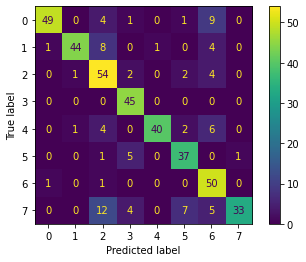

In [149]:
plot_confusion_matrix(clf, X_test, y_test, values_format='d', display_labels=['0', '1', '2', '3', '4', '5', '6', '7'])

In [150]:
paramGrid = [{
    'C': [0.5, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}]

optimalParam = GridSearchCV(
    SVC(),
    paramGrid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimalParam.fit(X_train, y_train)

print(optimalParam.best_params_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


In [151]:
clf = SVC(random_state=69, C=10, gamma=0.0001, probability=True)
clf.fit(X_train, y_train)

SVC(C=10, gamma=0.0001, probability=True, random_state=69)

C:\Users\Intouch\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


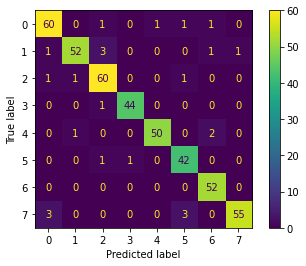

In [152]:
plot_confusion_matrix(clf, X_test, y_test, values_format='d', display_labels=['0', '1', '2', '3', '4', '5', '6', '7'])

In [157]:
pred = clf.predict(X_test)

print(accuracy_score(y_test, pred))

0.9431818181818182


In [158]:
pickle.dump(clf, open('./saved_models/SVM_Classification.sav', 'wb'))

In [159]:
fileName = 'Test/chord/Em.wav'
audio, sampleRate = librosa.load(fileName, res_type='kaiser_fast')

mfcc = librosa.feature.mfcc(y=audio, sr=sampleRate, n_mfcc=40)
mfccScaled = np.mean(mfcc.T, axis=0)
mfccScaled = mfccScaled.reshape(1, -1)

predictedLabel = np.array(clf.predict(mfccScaled))

if predictedLabel[0] == 0:
    predictedClass = 'Am'
elif predictedLabel[0] == 1:
    predictedClass = 'Bb'
elif predictedLabel[0] == 2:
    predictedClass = 'Bdim'
elif predictedLabel[0] == 3:
    predictedClass = 'C'
elif predictedLabel[0] == 4:
    predictedClass = 'Dm'
elif predictedLabel[0] == 5:
    predictedClass = 'Em'
elif predictedLabel[0] == 6:
    predictedClass = 'F'
elif predictedLabel[0] == 7:
    predictedClass = 'G'

confidenceLevel = np.max(clf.predict_proba(mfccScaled))

print(predictedClass, '{0:.2f} %'.format(confidenceLevel * 100))

Em 59.60 %


C:\Users\Intouch\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Intouch\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [ ]:
RATE = 44100
seconds = 3

recording = sd.rec(int(seconds * RATE), samplerate=RATE, channels=1)
sd.wait()

mfcc = librosa.feature.mfcc(y=recording.ravel(), sr=RATE, n_mfcc=40)
mfccScaled = np.mean(mfcc.T, axis=0)
mfccScaled = mfccScaled.reshape(1, -1)

predictedLabel = np.array(clf.predict(mfccScaled))

if predictedLabel[0] == 0:
    predictedClass = 'Am'
elif predictedLabel[0] == 1:
    predictedClass = 'Bb'
elif predictedLabel[0] == 2:
    predictedClass = 'Bdim'
elif predictedLabel[0] == 3:
    predictedClass = 'C'
elif predictedLabel[0] == 4:
    predictedClass = 'Dm'
elif predictedLabel[0] == 5:
    predictedClass = 'Em'
elif predictedLabel[0] == 6:
    predictedClass = 'F'
elif predictedLabel[0] == 7:
    predictedClass = 'G'

confidenceLevel = np.max(clf.predict_proba(mfccScaled))

print(predictedClass, '{0:.2f} %'.format(confidenceLevel * 100))

Bdim 58.07 %


C:\Users\Intouch\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Intouch\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
